Am now messing around with complex amplitude amaking sure my interference, transmission, reflection etc is actually correct. This is to make the outcoming interferogram look a little more real?

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import itertools
from mpl_toolkits.mplot3d import Axes3D
from RayTraceFun_forDet import *
from PossibleFunctionsDet import *
from BackgroundDet import *
from random import uniform
import random
import matplotlib
import pickle
import time #to save figs automatically time.strftime("%Y_%m_%d_%s")
#%matplotlib auto


In [20]:
#the functions that incorporate movement of mirror
def OFDM(Rays,y): #output from detector wiht mirror at Y
    Rayf = []
    for i in range(len(Rays)):
        Paths = [TTTTioM,RRRRioM,TTRRioM,RTTRioM,RTRTioM,TRRTioM,RRTTioM,TRTRioM]
        Ri = Rays[i]
        for j in range(8):
            origin = (0,y,0)
            out = Paths[j](Ri,p1,p2,p3,p4,origin)
            if out is not None:
                Rayf.append(out)
    return Rayf

def checkoutraysM(Rays,center,r): #RAYS THAT HIT DETECTOR
    GRays = []
    for i in range(len(Rays)):
        det = PLINTzS(80.,Rays[i][2],Rays[i][3])
        Rays[i][2] = det
        Rays[i][0] = Rays[i][0] + np.pi #reflection changes polarization
        d = ((det[0]-center[0])**2) + ((det[1]-center[1])**2) #if it is within detector
        if d <= r**2: 
            GRays.append(Rays[i])
    return GRays

def RunRaysM(n,y): #just give number of rays to be run through this FTS at a specific y!
    sourcepointorigin = [-160.375,-113.,-80.0] #LOCAL 
    sourcethet = [0.,0.,0.] #SHOT STRAIGHT UP
    sourcepoints = specsource(7.9375,sourcepointorigin,sourcethet,n) #LOCAL
    Rays = FSRay(n,sourcepoints, sourcethet,origin10)
    Rayf = OFDM(Rays,y)
    G= checkoutraysM(Rayf,[160.375,-113],7.9375) # GOOD RAYS ONLY 
    Gtestsorted = sortgrid(G)
    Regions = regionalize(Gtestsorted)
    return Gtestsorted,Regions

def SumjRegionsM(n,y): #ALSO INCORPORATES PHASE
    OutRays,regions=RunRaysM(n,y)
    Regions = list(regions)
    jx,jy = gridlines(7.9375,[160.375,-113],200)
    LamdAll = np.linspace(1, 10,300) #possible wavelengths (30-300 Ghz), steps of 1Ghz
    DetTot = []
    for j in range(len(regions)):
        for i in range(len(Regions[j])): #All rays in region j
            ExTot = []
            EyTot = []
            if i != 0 and i != 1:
                JRegion = Regions[j]
                o,p = JRegion[0],JRegion[1] # jx and jy defining the jth region
                Raym = OutRays[JRegion[i]] #ith ray in the jth region
                if o != len(jx)-1 and p !=len(jy)-1:
                    w = gaussian3d(Raym[2][0],Raym[2][1],.4,(jx[o]+jx[o+1])/2,(jy[p]+jy[p+1])/2)
                else: 
                    w = 0 #(skipping gaussian)
                #Raym[1] is intensity!!! #split into x and y components of AMPLITUDE field
                I = Raym[1]
                thet = Raym[0]
                Ex1,Ey1 = w*np.sqrt(I)*np.cos(thet),w*np.sqrt(I)*np.sin(thet) #multiplied by gaussian
                #incorporating phase 
                for q in range(300):
                    Lamd=LamdAll[q]
                    Ex = Ex1*np.cos((Raym[4]%Lamd)*2*np.pi/Lamd)
                    Ey = Ey1*np.cos((Raym[4]%Lamd)*2*np.pi/Lamd)
                    ExTot.append(Ex)
                    EyTot.append(Ey)
        Ij = (np.sum(ExTot))**2 + (np.sum(EyTot))**2
        DetTot.append(Ij)
    return np.sum(DetTot)

def RunFTSLim(n,div,Lim):
    Power = []
    Delay = []
    for y in np.linspace(-int(Lim),int(Lim),div):
        I = SumjRegionsM(n,y)
        Power.append(I)
        Delay.append(y)
    return Power,Delay   

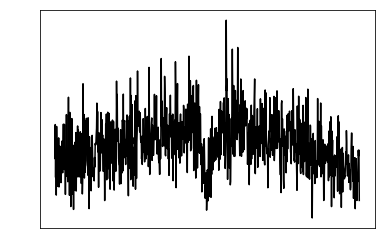

In [29]:
P,D = RunFTSLim(300,900,30)
pl.plot(D,P,color = 'black')
pl.tick_params(colors = 'white')
pl.savefig('Plots/'+time.strftime("%Y_%m_%d_%H_%M_%S"))
pl.show()

with open("Plots/ModelDelays"+time.strftime("_%Y_%m_%d_%H_%M_%S") + ".pkl", "wb") as f:
    pickle.dump(D,f)
with open("Plots/ModelPower"+time.strftime("_%Y_%m_%d_%H_%M_%S") + ".pkl", "wb") as f:
    pickle.dump(P,f)